In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Sebuah model bernama Natural Language Processing (NLP) adalah sub area dari artificial intelegence (AI) yang berfokus untuk membuat komputer mengerti dan memproses bahasa manusia seperti halnya manusia itu sendiri. Salah satu contoh pengaplikasian NLP yaitu untuk mengidentifikasi pesan masuk sebagai spam atau bukan. 
Di bawah ini adalah query python untuk membuat model NLP dalam identifikasi pesan sebagai spam atau bukan.

In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = [line.strip() for line in open('../input/SMSSpamCollection')]

print(len(df))

5574


In [3]:
for message_no, df in enumerate(df[:5]):
    print(message_no, df)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though




Dapat terlihat kalau datanya berupa TSV (tab separated values), dengan pengertian datanya menggunakan spasi untuk memisahkan antar data. 
Kolom pertama adalah kolom label untuk pesan yang ada di kolom kedua. Di kolom pertama dapat dilihat apakah pesan yang ada di kolom kedua sebuah spam atau bukan (ham).
Dengan menggunakan data dengan dua kolom tersebut, kita akan membangun model yang akan membedakan antara pesan spam atau bukan. 

In [4]:
import pandas as pd

In [5]:
messages = pd.read_csv('../input/SMSSpamCollection', sep='\t', names=["label", "message"])

messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [7]:
messages.groupby('label').describe()

message ...      
        count ...  freq
label         ...      
ham      4825 ...    30
spam      747 ...     4

[2 rows x 4 columns]

Semakin banyak feature yang dimasukan ke model, maka akan membuat model tersebut semakin bagus. Jadi, kali ini kita akan menambah feature baru yaitu data seberapa panjang pesan tsb.

In [8]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Selanjutnya, untuk mengetahui secara visual tentang data, maka perlu dilakukan data visualization. 

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

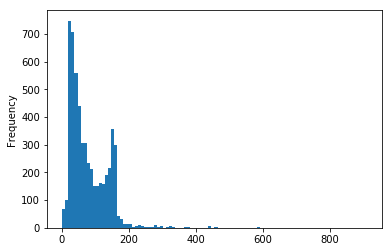

In [10]:
messages['length'].plot(bins=100, kind='hist')

Dari grafik di atas diketahui bahwa ada pesan dengan panjang sampai lebuh dari 400 atau bahkan sampai mendekati 600 panjangnya. Untuk mengetahui lebih lanjut, maka selanjutnya akan dilakukan anaisa deskriptif.

In [11]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

Atau bahkan ada yang mempunyai panjang 910 berdasarkan analisa deskriptif di atas. Apakah isi dari isi pesan panjang tsb?

In [12]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9eb56b6e48>,
      dtype=object)

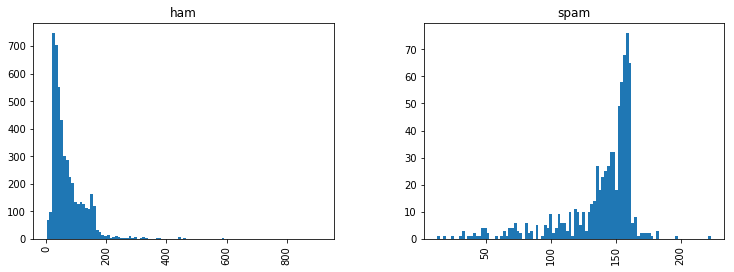

In [13]:
messages.hist(column='length', by='label', bins=100, figsize=(12,4))

Dari visualisasi di atas dapat diketahui kalau pesan spam cenderung lebih panjang. Selanjutnya 

Text Pre-Processing
Model ML hanya bisa menggunakan data berupa numerik. Sedangkan data SMS ini merupakan data kumpulan teks atau strings. Jadi kita akan melakukan langkah-langkah berikut:
1. Menghilangkan tanda baca (punctuation) dengan menggunakan string library.
2. Menghilangkan common words atau stopwords seperti "the", "a", dan lain-lain. Untuk melakukan ini kita menggunakan NLTK library.
3. Pendekatan bag-of-words untuk mengkonversi data teks (corpus) menjadi format vektor (kumpulan angka-angka).

Untuk langkah 1 dan 2 dapat dilakukan dengan membuat fungsi di bawah ini. Nama fungsinya yaitu text_process.

In [14]:
import string
from nltk.corpus import stopwords

In [15]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    #Cek apakah karakternya berupa tanda baca (punctuation)
    nopunc = [char for char in mess if char not in string.punctuation]
    
    #Menggabungkan karakter-karakternya lagi untuk membentuk data string
    nopunc = ''.join(nopunc)
    
    #Menghilangkan stopwords
    clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    return clean_mess

Setelah membuat fungsi di atas, kita masukan kolom message di data messages ke dalam fungsi tsb seperti query di bawah ini. Dan hasilnya kita coba tampilkan 5 teratasnya. Langkah ini juga disebut proses tokenize.

In [16]:
messages['message'].head(5).apply(text_process)[3]

['U', 'dun', 'say', 'early', 'hor', 'U', 'c', 'already', 'say']

In [17]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Langkah 3. Pendekatan bag-of-words untuk mengkonversi data teks (corpus) menjadi format vektor (kumpulan angka-angka).
Sampai dengan tahap ini, kita sudah mempunyai data messaes sebagai list dari token atau disebut juga sebagai lemmas.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

In [20]:
print(len(bow_transformer.vocabulary_))

11425


In [21]:
bow_transformer.vocabulary_

{'Go': 2060,
 'jurong': 7555,
 'point': 8917,
 'crazy': 5769,
 'Available': 1110,
 'bugis': 5218,
 'n': 8336,
 'great': 6937,
 'world': 11163,
 'la': 7668,
 'e': 6217,
 'buffet': 5217,
 'Cine': 1483,
 'got': 6906,
 'amore': 4653,
 'wat': 10965,
 'Ok': 3064,
 'lar': 7701,
 'Joking': 2451,
 'wif': 11072,
 'u': 10698,
 'oni': 8590,
 'Free': 1941,
 'entry': 6331,
 '2': 423,
 'wkly': 11123,
 'comp': 5619,
 'win': 11084,
 'FA': 1833,
 'Cup': 1551,
 'final': 6557,
 'tkts': 10512,
 '21st': 443,
 'May': 2804,
 '2005': 430,
 'Text': 3953,
 '87121': 871,
 'receive': 9252,
 'questionstd': 9159,
 'txt': 10686,
 'rateTCs': 9200,
 'apply': 4731,
 '08452810075over18s': 73,
 'U': 4068,
 'dun': 6204,
 'say': 9554,
 'early': 6222,
 'hor': 7186,
 'c': 5261,
 'already': 4629,
 'Nah': 2948,
 'dont': 6123,
 'think': 10433,
 'goes': 6877,
 'usf': 10799,
 'lives': 7842,
 'around': 4777,
 'though': 10450,
 'FreeMsg': 1943,
 'Hey': 2222,
 'darling': 5864,
 '3': 543,
 'weeks': 11011,
 'word': 11150,
 'back': 4893

In [22]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


Di atas message ke 4 dari data yg sebelum di vectorization, sedangkan di bawah ini setelah dilakukan vectorization.

In [23]:
bow4 = bow_transformer.transform([message4])
print(bow4)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2


Dari tampilan di atas dapat diketahui kalau ada dua kata (word) yang muncul dua kali, yaitu "4068" dan "9554".

In [24]:
print(bow_transformer.get_feature_names()[4068])
print(bow_transformer.get_feature_names()[9554])

U
say


Sampai tahap ini, kita mendapatkan data berupa list. Jadi selanjutnya kita akan transform objek yang ada di Bag-of-Words.

In [25]:
messages_bow = bow_transformer.transform(messages['message'])

In [26]:
print('Shape of Sparse matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [27]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


Langkah selanjutnya yaitu melakukan weight untuk masing-masing kata yang nanti akhirnya masing-masing kata akan mempunyai nilai weight yang berbeda-beda. Untuk melakukan weight ini digunakan TF-IDF (term frequency-inverse document frequency).

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


Hanya untuk cek fungsi dari query di atas, kita akan cek kata "u" dan "university"

In [29]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.2800524267409408
8.527076498901426


Sedangkan untuk mentransformasi semua bagian bag-of-words ke TF-IDF, maka query-nya sebagai berikut:

In [30]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


**Membuat Model** 
Menggunakan algoritma Naive Bayes classifier.

In [32]:
messages_tfidf

<5572x11425 sparse matrix of type '<class 'numpy.float64'>'
	with 50548 stored elements in Compressed Sparse Row format>

In [33]:
messages.label.head()

0     ham
1     ham
2    spam
3     ham
4     ham
Name: label, dtype: object

In [34]:
from sklearn.naive_bayes import MultinomialNB

spam_detect_model = MultinomialNB()
spam_detect_model.fit(messages_tfidf, messages['label'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [36]:
print('predicted: ', spam_detect_model.predict(tfidf4)[0])
print('expected: ', messages.label[3])

predicted:  ham
expected:  ham


**Evalusai model**

In [37]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [38]:
from sklearn.metrics import classification_report,confusion_matrix
print (classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

   micro avg       0.98      0.98      0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



In [40]:
print(confusion_matrix(messages['label'], all_predictions))

[[4825    0]
 [ 115  632]]
